In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import glob 

path = 'data/PRSA_Data_20130301-20170228/'
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = [pd.read_csv(file) for file in csv_files]

In [3]:
def pre_process(df):
    df['date_time']=pd.to_datetime(df[['year', 'month', 'day','hour']])
    df.drop(columns=['year', 'month', 'day','hour','No'],inplace=True)
    df.set_index('date_time',inplace=True)
    return df

In [4]:
df_preprocessed=[pre_process(df) for df in df_list]

In [5]:
df_group=pd.concat(df_preprocessed)

In [6]:
df_group

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
date_time,,,,,,,,,,,,,
2013-03-01 00:00:00,6.0,18.0,5.0,NaN,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng
2013-03-01 01:00:00,6.0,15.0,5.0,NaN,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0,Gucheng
2013-03-01 02:00:00,5.0,18.0,NaN,NaN,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6,Gucheng
2013-03-01 03:00:00,6.0,20.0,6.0,NaN,NaN,NaN,-1.0,1022.7,-21.2,0.0,W,2.8,Gucheng
2013-03-01 04:00:00,5.0,17.0,5.0,NaN,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6,Gucheng
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,27.0,72.0,8.0,92.0,800.0,16.0,10.3,1014.2,-12.4,0.0,W,1.8,Shunyi
2017-02-28 20:00:00,47.0,55.0,17.0,86.0,1100.0,19.0,9.8,1014.5,-9.9,0.0,NW,1.5,Shunyi
2017-02-28 21:00:00,18.0,28.0,4.0,30.0,500.0,64.0,9.1,1014.6,-12.7,0.0,NE,1.7,Shunyi


In [7]:
df_group.columns

Index(['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'wd', 'WSPM', 'station'],
      dtype='object')

In [8]:

import math
import datetime
import numpy as np 
 


def train_test_split(data,split_fraction,feature_keys):
    data=data[feature_keys]
    train_split = int(split_fraction * int(data.shape[0]))
    data=data._get_numeric_data()
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    data = (data - data_mean) / data_std
    train_data = data.iloc[0 : train_split - 1]
    val_data = data.iloc[train_split:]
    return train_data,val_data

def train_test_split_cyclical_only(data,split_fraction,feature_keys):
    data=data[feature_keys]
    wind_direction={'NNW': 337.5, 'N': 0, 'NW': 315.0, 'NNE': 22.5, 'ENE': 67.5, 'E': 90, 'NE': 45.0, 'W': 270, 'SSW': 202.5, 'WSW': 247.5, 'SE': 135.0, 'WNW': 292.5, 'SSE': 157.5, 'ESE': 112.5, 'S': 180, 'SW': 225.0}
    wdn={i:(wind_direction[i]-min(wind_direction.values()))/(max(wind_direction.values())-min(wind_direction.values())) for i in wind_direction}
    day=24*60*60
    timestamp_s=pd.to_datetime(data.index).map(datetime.datetime.timestamp)
    data['day_sin']=(np.sin(timestamp_s* (2*np.pi/day))).values
    data['day_cos']=(np.cos(timestamp_s* (2*np.pi/day))).values
    data['wd_sin']=data['wd'].map(wind_direction).map(np.sin)
    data['wd_cos']=data['wd'].map(wind_direction).map(np.cos)
    data=data._get_numeric_data()
    train_split = int(split_fraction * int(data.shape[0]))
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    data = (data - data_mean) / data_std
    train_data = data.iloc[0 : train_split - 1]
    val_data = data.iloc[train_split:]
    return train_data,val_data

def create_batch(data,lag,future):
    df_lag=pd.concat([data[:-future].shift(i) for i in range(lag-1,-1,-1)],axis=1).dropna()
    #df_lag.columns=['pm_'+str(i) for i in range(lag,-1,1)]
    X=df_lag.values
    y=data[future+lag-1:].values
    return X,y

def create_batch_multistep(df,lag,future,feature=None):
    if feature is None:
        data=df
    else:
        data=df[feature]
    data.fillna(0.0,inplace=True)
    df_lag=pd.concat([data[:-future].shift(i) for i in range(lag-1,-1,-1)],axis=1).dropna()
    df_future=pd.concat([data[lag-1:].shift(-i) for i in range(1,future+1)],axis=1).dropna()
    #df_lag.columns=['pm_'+str(i) for i in range(lag,-1,1)]
    X=df_lag.values
    y=df_future.values
    return X,y

In [9]:
future=6
past=6

In [10]:
import numpy as np 

split_fraction = 0.8
feature_keys = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'wd','WSPM']
X_train_datasets=list()
y_train_datasets=list()
X_test_datasets=list()
y_test_datasets=list()

dataset_names=list()
for item_id, gdf in df_group.groupby('station'):
    gdf.fillna(method='ffill',inplace=True)
    train,test=train_test_split_cyclical_only(gdf,split_fraction,feature_keys)
    train_multi_feature=list()
    test_multi_feature=list()
    for feature in train.columns:
        X_train,y_train=create_batch_multistep(train,past,future,feature)
        X_test,y_test=create_batch_multistep(test,past,future,feature)
        train_multi_feature.append(X_train)
        test_multi_feature.append(X_test)
        if feature=='PM2.5':
            y_train_datasets.append(y_train)
            y_test_datasets.append(y_test)
    X_train_datasets.append(np.stack(train_multi_feature,axis=-1))
    X_test_datasets.append(np.stack(test_multi_feature,axis=-1))
    dataset_names.append(item_id)
X_train_datasets=np.stack(X_train_datasets,axis=0)
y_train_datasets=np.stack(y_train_datasets,axis=0)
X_test_datasets=np.stack(X_test_datasets,axis=0)
y_test_datasets=np.stack(y_test_datasets,axis=0)

In [19]:
X_train_datasets.shape

(12, 28039, 6, 15)

In [23]:
import optax
from flax import linen as nn
from functools import partial
import distrax

class LSTM(nn.Module):

    @nn.remat    
    @nn.compact   
    def __call__(self, X_batch):
        carry,x=nn.RNN(nn.LSTMCell(32),return_carry=True)(X_batch)
        #carry,x=nn.RNN(nn.LSTMCell(32),return_carry=True)(x)
        x=nn.elu(x)
        x=nn.Dense(future)(x)
        return x[:,-1,:]
    

def reparameterize(params):
    mu = params['mu']
    sigma = jax.tree_map(lambda p : jnp.exp(0.5*p),params['log_std'])
    eps = params['eps']
    #eps=jax.tree_map(lambda p: jax.random.normal(key=jax.random.PRNGKey(np.random.randint(42)),shape=p.shape), params['eps'])
    model_params = jax.tree_map(lambda m,e,s : m+e*s,mu,eps,sigma)
    return model_params

def log_likelihood(params, x, y):
    model_params=reparameterize(params)
    preds = jax.vmap(model.apply, (0, 0))(model_params, jnp.array(x))
    sigmas = jax.vmap(model.apply, (None, 0))(params['log_sigma'], jnp.array(x))
    sigmas=jax.tree_map(lambda p: jax.nn.softplus(p),sigmas)
    return -1.0*jnp.mean(distrax.Normal(preds,sigmas).log_prob(y).sum(axis=-1))

def log_prior(params):
    def flatten(params):
        squared=jax.tree_map(lambda p: distrax.Normal(0.0,20.0).log_prob(p).sum(), params)
        flattten_squared=jnp.sum(jnp.stack(jax.tree_util.tree_leaves(squared['params'])))
        return flattten_squared
    squared_mu=flatten(params['mu'])
    squared_noise=flatten(params['eps'])
    squared_std=flatten(params['log_std'])
    return squared_std+squared_noise+squared_mu

def log_post(params,batch,labels):
    n_data=batch.shape[0]
    return -1./n_data*log_prior(params) + log_likelihood(params,batch,labels)

grad_log_post=jax.jit(jax.grad(log_post))

In [28]:
@partial(jax.jit, static_argnums=(3,4))
def sgld_kernel_momemtum(key, params, momemtum,grad_log_post, dt, X, y_data):
    gamma,eps=0.9,1e-6
    key, subkey = jax.random.split(key, 2)
    grads = grad_log_post(params, X, y_data)
    squared_grads=jax.tree_map(lambda g: jnp.square(g),grads)
    momemtum=jax.tree_map(lambda m,s : gamma*m+(1-gamma)*s,momemtum,squared_grads)
    noise=jax.tree_map(lambda p: jax.random.normal(key=subkey,shape=p.shape), params)
    params=jax.tree_map(lambda p, g,m,n: p-0.5*dt*g/(m+eps)+jnp.sqrt(dt)*n, params, grads,momemtum,noise)
    return key, params,momemtum

def sgld(key,log_post, grad_log_post, num_samples,
                             dt, x_0,X_train_datasets,y_train_datasets,batch_size,
                             test_data=None):
    samples = list()
    loss=list()
    param = x_0
    key_data, key_model = jax.random.split(key, 2)
    momemtum=jax.tree_map(lambda p:jnp.zeros_like(p),param)
    key_data_batch=jax.random.split(key_data, num_samples)
    for i in range(num_samples):
        train_data=get_dataloader(X_train_datasets,y_train_datasets,batch_size,key_data_batch[i],axis=1)
        for _,(X_batch, y_batch) in enumerate(train_data):
            key_model,param,momemtum = sgld_kernel_momemtum(key_model, param,momemtum, grad_log_post, dt, X_batch, y_batch)
        loss.append(log_post(param,X_batch,y_batch))
        samples.append(param)
        if (i%(num_samples//10)==0):
            print('iteration {0}, loss {1:.2f}'.format(i,loss[-1]))
    return samples,loss



In [29]:
key=jax.random.PRNGKey(0)
key_model,key_data=jax.random.split(key,2)
batch_size=256

In [30]:
model=LSTM()
n_groups=X_train_datasets.shape[0]
features=X_train_datasets.shape[-1]
inputs = jax.random.randint(key,(batch_size,past,features),0, 10,).astype(jnp.float32)

In [31]:
inputs.shape

(256, 6, 15)

In [32]:
key_model_init, key_state_init = jax.random.split(key_model, 2)
key_params_mu,key_params_sigma,key_params_eps,key_params_aleatoric=jax.random.split(key_model_init,4)
key_tasks=jax.random.split(key_params_eps,n_groups)

params_noise = jax.vmap(model.init, (0, None))(key_tasks, inputs)
#params_noise=model.init(key_params_eps,inputs)
params_mu=model.init(key_params_mu,inputs)

params_sigma=model.init(key_params_sigma,inputs)
params_aleatoric=model.init(key_params_aleatoric,inputs)
#jax.tree_map(lambda p: distrax.Normal(0.0,1.0).sample(seed=key_params_sigma,sample_shape=(1,)),params_mu)


params_pooled = {
    'mu': params_mu,
    'eps': params_noise,
    'log_std': params_sigma,
    'log_sigma': params_aleatoric
}
model_params=reparameterize(params_pooled)

In [33]:
model_params=reparameterize(params_pooled)
batch_inputs = jax.random.randint(key_data,(n_groups,batch_size,past,features),0, 10,).astype(jnp.float32)
preds = jax.vmap(model.apply, (0, 0))(model_params, batch_inputs)


In [34]:
preds.shape

(12, 256, 6)

In [35]:
dt=1e-5
samples,loss=sgld(key_data,log_likelihood, grad_log_post, 100,
                             dt, params_pooled,X_train_datasets,y_train_datasets,
                             batch_size,test_data=None)

iteration 0, loss 4.14
iteration 10, loss 2.05
iteration 20, loss 0.61
iteration 30, loss -0.11
iteration 40, loss 0.91
iteration 50, loss 0.59
iteration 60, loss 1.26
iteration 70, loss 1.05
iteration 80, loss 0.80
iteration 90, loss 0.51


In [36]:
X_test=X_test_datasets
model_params=reparameterize(samples[-1])
preds=jax.vmap(model.apply, (0, 0))(model_params, X_test)

In [37]:
from sklearn import metrics

r_metric=list()
rmse_metric=list()
mae_metric=list()
stations=list()
periods=list()
for i in range(n_groups):
    for j in range(future):
        r_squared=metrics.r2_score(preds[i,:,j],y_test_datasets[i,:,j])
        rmse=metrics.mean_squared_error(preds[i,:,j],y_test_datasets[i,:,j],squared=True)
        mae=metrics.mean_absolute_error(preds[i,:,j],y_test_datasets[i,:,j])
        periods.append(j)
        stations.append(dataset_names[i])
        #print('forecast period : {4}, task : {0}, RMSE : {1:1.2f}, MAE :{2:1.2f}, R2 :{3:1.2f}'.format(dataset_names[i],rmse,mae,r_squared,j))
        r_metric.append(r_squared)
        rmse_metric.append(rmse)
        mae_metric.append(mae) 
print('-------------------------------------------------------')
print('RMSE : {0:1.2f}, MAE :{1:1.2f}, R2 :{2:1.2f}'.format(np.mean(rmse_metric),np.mean(mae_metric),np.mean(r_metric)))

-------------------------------------------------------
RMSE : 0.24, MAE :0.27, R2 :0.69


In [38]:
df_results=pd.DataFrame({'stations':stations,
                         'periods':periods,
                         'RMSE':rmse_metric,
                         'MAE':mae_metric,
                         'R2':r_metric})
df_results.periods=df_results['periods'].astype("category")

/home/sergio/code/tf/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


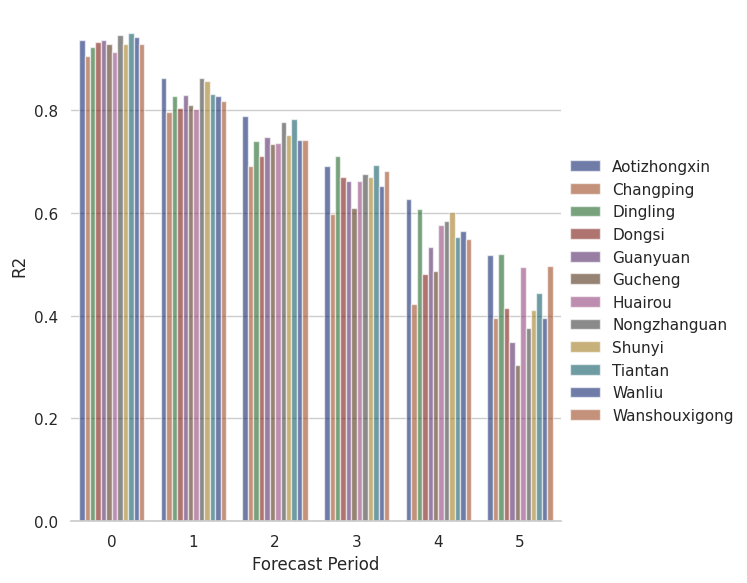

In [39]:
import seaborn as sns
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=df_results, kind="bar",
    x="periods", y="R2", hue="stations",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Forecast Period", "R2")
g.legend.set_title("")

/home/sergio/code/tf/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


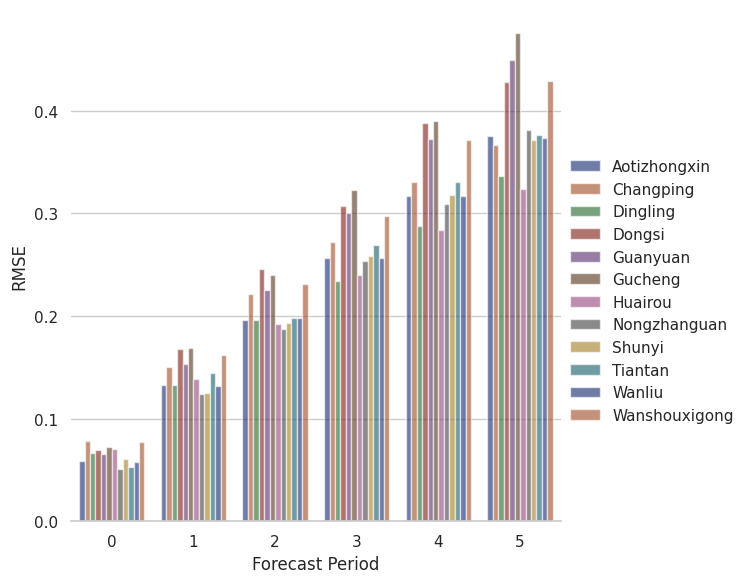

In [40]:
g = sns.catplot(
    data=df_results, kind="bar",
    x="periods", y="RMSE", hue="stations",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Forecast Period", "RMSE")
g.legend.set_title("")

/home/sergio/code/tf/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


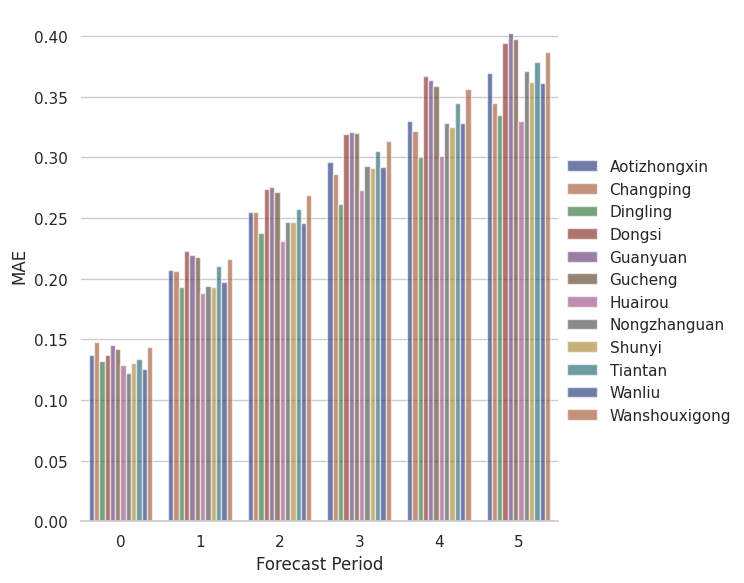

In [41]:
g = sns.catplot(
    data=df_results, kind="bar",
    x="periods", y="MAE", hue="stations",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Forecast Period", "MAE")
g.legend.set_title("")

In [42]:
ensemble_pred=list()
for i in range(len(samples)):
    model_params=reparameterize(samples[i])
    preds=jax.vmap(model.apply, (0, 0))(model_params, X_test)
    ensemble_pred.append(preds)

In [43]:
ensemble_pred=np.stack(ensemble_pred,axis=2)

In [44]:
ensemble_pred.shape

(12, 7002, 100, 6)

In [45]:
mean_pred=np.mean(ensemble_pred,axis=2)
std_pred=np.std(ensemble_pred,axis=2)

In [46]:

r_metric=list()
rmse_metric=list()
mae_metric=list()
stations=list()
periods=list()
for i in range(n_groups):
    for j in range(future):
        r_squared=metrics.r2_score(mean_pred[i,:,j],y_test_datasets[i,:,j])
        rmse=metrics.mean_squared_error(mean_pred[i,:,j],y_test_datasets[i,:,j],squared=True)
        mae=metrics.mean_absolute_error(mean_pred[i,:,j],y_test_datasets[i,:,j])
        periods.append(j)
        stations.append(dataset_names[i])
        #print('forecast period : {4}, task : {0}, RMSE : {1:1.2f}, MAE :{2:1.2f}, R2 :{3:1.2f}'.format(dataset_names[i],rmse,mae,r_squared,j))
        r_metric.append(r_squared)
        rmse_metric.append(rmse)
        mae_metric.append(mae) 
print('-------------------------------------------------------')
print('RMSE : {0:1.2f}, MAE :{1:1.2f}, R2 :{2:1.2f}'.format(np.mean(rmse_metric),np.mean(mae_metric),np.mean(r_metric)))

-------------------------------------------------------
RMSE : 0.22, MAE :0.26, R2 :0.70


In [47]:
df_results_ensemble=pd.DataFrame({'stations':stations,
                         'periods':periods,
                         'RMSE':rmse_metric,
                         'MAE':mae_metric,
                         'R2':r_metric})
df_results_ensemble.periods=df_results_ensemble['periods'].astype("category")

/home/sergio/code/tf/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


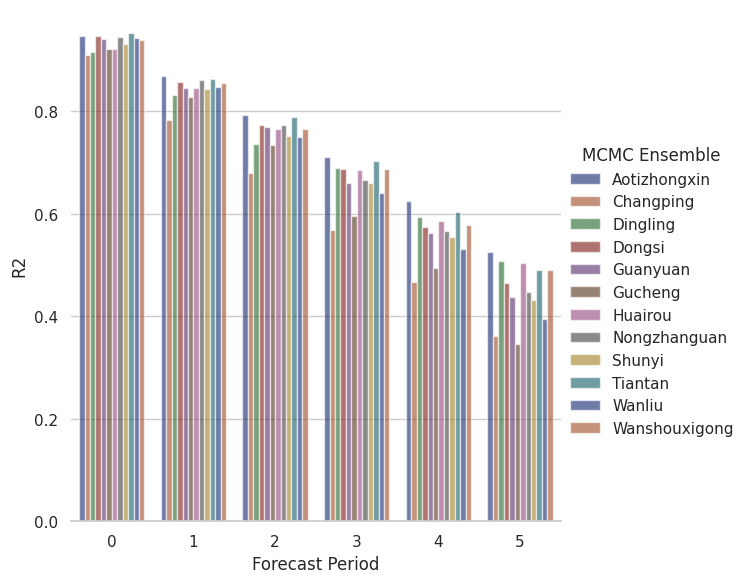

In [48]:
g = sns.catplot(
    data=df_results_ensemble, kind="bar",
    x="periods", y="R2", hue="stations",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Forecast Period", "R2")
g.legend.set_title("MCMC Ensemble")

In [49]:
y_test_datasets[0,:23,1].shape

(23,)

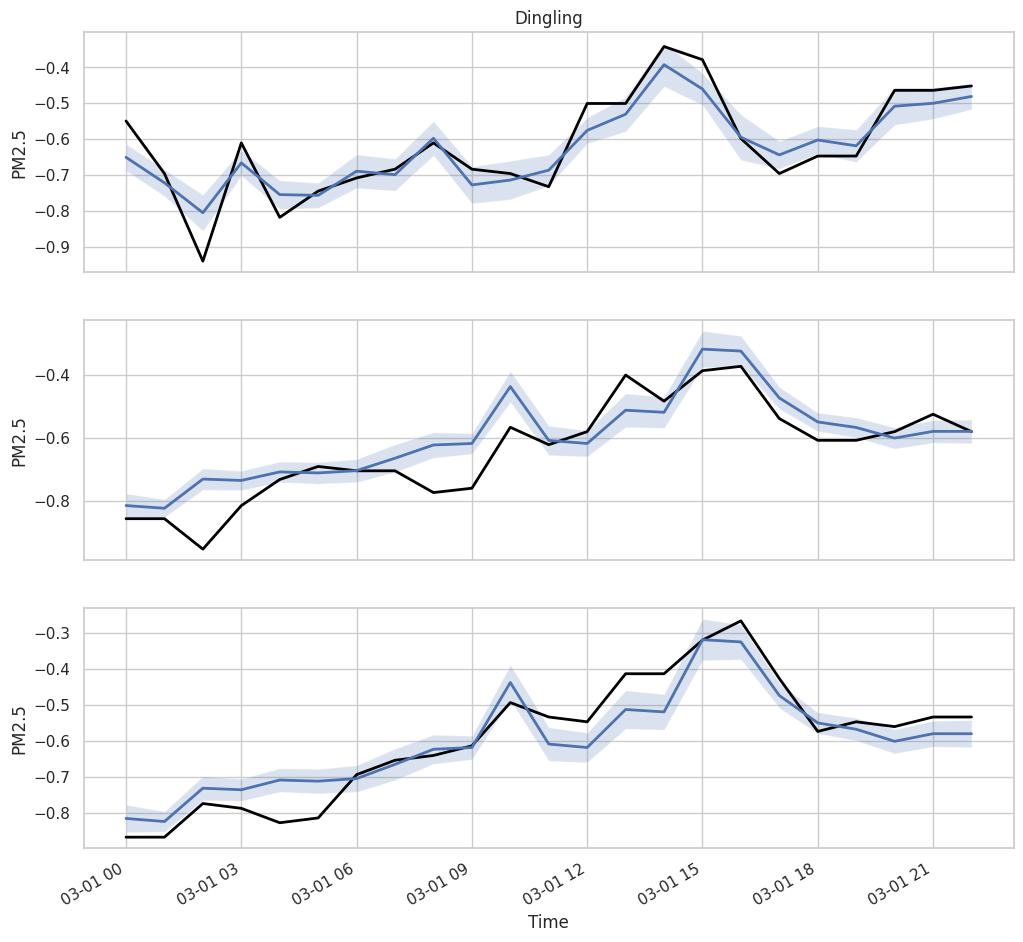

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 12))

future_pred=1
names=np.ravel(gdf.index[0:23].to_frame().values)
ax1.plot(names,y_test_datasets[0,:23,future_pred], linewidth=2,color="black")
ax1.plot(names,mean_pred[0,2:25,future_pred], linewidth=2)
ax1.fill_between(names,np.ravel(mean_pred[0,2:25,future_pred]-std_pred[0,2:25,future_pred]),np.ravel(mean_pred[0,2:25,future_pred]+std_pred[0,2:25,future_pred]),alpha=0.2)
ax1.set_xlabel('Time')
ax1.set_ylabel('PM2.5')
#ax1.legend(dataset_names[0], loc="upper left", fontsize="xx-large")
ax1.grid(True)

ax2.plot(names,y_test_datasets[1,:23,future_pred], linewidth=2,color="black")
ax2.plot(names,mean_pred[2,2:25,future_pred], linewidth=2)
ax2.fill_between(names,np.ravel(mean_pred[2,2:25,future_pred]-std_pred[2,2:25,future_pred]),np.ravel(mean_pred[2,2:25,future_pred]+std_pred[2,2:25,future_pred]),alpha=0.2)
ax2.set_xlabel('Time')
ax2.set_ylabel('PM2.5')
ax1.set_title(dataset_names[1])
ax2.grid(True)

ax3.plot(names,y_test_datasets[2,:23,future_pred], linewidth=2,color="black")
ax3.plot(names,mean_pred[2,2:25,future_pred], linewidth=2)
ax3.fill_between(names,np.ravel(mean_pred[2,2:25,future_pred]-std_pred[2,2:25,future_pred]),np.ravel(mean_pred[2,2:25,future_pred]+std_pred[2,2:25,future_pred]),alpha=0.2)
ax3.set_xlabel('Time')
ax3.set_ylabel('PM2.5')
ax1.set_title(dataset_names[2])
ax3.grid(True)

fig.autofmt_xdate()

In [51]:
def quantization(x, s, z, alpha_q, beta_q):
    x_q = np.round(1 / s * x + z, decimals=0)
    x_q = np.clip(x_q, a_min=alpha_q, a_max=beta_q)
    return x_q


def quantization_int8(x, s, z):
    x_q = quantization(x, s, z, alpha_q=-128, beta_q=127)
    x_q = x_q.astype(np.int8)
    return x_q

def dequantization(x_q, s, z):
    # x_q - z might go outside the quantization range.
    x_q = x_q.astype(np.int32)
    x = s * (x_q - z)
    x = x.astype(np.float64)
    return x


def generate_quantization_constants(alpha, beta, alpha_q, beta_q):
    # Affine quantization mapping
    s = (beta - alpha) / (beta_q - alpha_q)
    z = int((beta * alpha_q - alpha * beta_q) / (beta - alpha))
    return s, z


def generate_quantization_int8_constants(alpha, beta):
    b = 8
    alpha_q = -2**(b - 1)
    beta_q = 2**(b - 1) - 1
    s, z = generate_quantization_constants(alpha=alpha,
                                           beta=beta,
                                           alpha_q=alpha_q,
                                           beta_q=beta_q)
    return s, z

In [1]:
from stein_thinning.stein import ksd, kmat
from stein_thinning.thinning import thin
from stein_thinning.kernel import make_imq, make_precon

def sgmcmc_diagnostic(samples,grads):
    numpy_grads=np.array(grads)
    ksd_samples=list()
    for i in range(samples.shape[0]):
        vfk0 = make_imq(samples[i,:],numpy_grads[i,:], pre='sclmed')
        ks_smp=ksd(samples[i,:],numpy_grads[i,:],vfk0)
        ksd_samples.append(np.sqrt(np.sum(ks_smp))/len(ks_smp))
    log_ksd = np.log10(ksd_samples)
    return log_ksd

def quantize_samples(samples):
    s=list()
    z=list()
    q_samples=np.zeros_like(samples).astype(np.int8)
    for i in range(samples.shape[0]):
        alpha=np.min(samples[i,:])
        beta=np.max(samples[i,:])
        ss,zz=generate_quantization_int8_constants(alpha,beta)
        x_q=quantization_int8(samples[i,:],ss,zz)
        q_samples[i,:]=x_q
        s.append(ss)
        z.append(zz)
    return q_samples,s,z

def dequantizate_samples(q_samples,s,z):
    samples=np.zeros_like(q_samples).astype(np.float16)
    for i in range(q_samples.shape[0]):
        samples[i,:]=dequantization(q_samples[i,:], s[i], z[i])
    return samples

In [53]:
grads=list()
for i in range(len(samples)):
    sample_grad = grad_log_post(samples[i], X_test, y_test)
    grads.append(sample_grad)

In [55]:

from jax.flatten_util import ravel_pytree

flatten_samples=ravel_pytree(samples)[0].reshape(len(samples), -1)
flatten_grads = ravel_pytree(grads)[0].reshape(len(grads), -1)

In [59]:
flatten_samples=np.asarray(flatten_samples)
flatten_grads=np.asarray(flatten_grads)

In [61]:
np.savez('data/posterior_samples_grads', flatten_samples, flatten_grads)


In [1]:
import numpy as np 
import jax 
import jax.numpy as jnp 

with np.load('data/posterior_samples_grads.npz') as data:
    flatten_samples= jnp.asarray(data['arr_0'])
    flatten_grads= jnp.asarray(data['arr_1'])


In [13]:
flatten_samples=flatten_samples.astype(np.float16)
flatten_grads=flatten_grads.astype(np.float16)

In [2]:
flatten_samples.dtype

dtype('float32')

In [3]:
from kernax.kernels import Energy
from kernax import SteinThinning

from kernax.utils import median_heuristic

lengthscale = jnp.array([median_heuristic(flatten_samples)])

In [6]:
stein_fn = SteinThinning(flatten_grads,flatten_samples, lengthscale)

In [8]:
index=stein_fn(50)

In [12]:
np.savez('data/thinned_index', index)

In [14]:
from kernax.discrepancies import KSD

KSD(flatten_samples,flatten_grads)

2024-01-03 12:16:17.099830: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.54GiB (rounded to 3805200128)requested by op 
2024-01-03 12:16:17.100017: W external/tsl/tsl/framework/bfc_allocator.cc:497] **************************************************************************************************__
2024-01-03 12:16:17.100118: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2593] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3805200000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   72.58MiB
              constant allocation:         0B
        maybe_live_out allocation:    3.54GiB
     preallocated temp allocation:         0B
                 total allocation:    3.61GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 3.54GiB
		Operator: op_name="jit(<lambda>)/jit(main)/sub" source

ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3805200000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   72.58MiB
              constant allocation:         0B
        maybe_live_out allocation:    3.54GiB
     preallocated temp allocation:         0B
                 total allocation:    3.61GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 3.54GiB
		Operator: op_name="jit(<lambda>)/jit(main)/sub" source_file="/home/sergio/code/tf/lib/python3.10/site-packages/kernax/kernels.py" source_line=89
		XLA Label: fusion
		Shape: f32[100,100,95130]
		==========================

	Buffer 2:
		Size: 36.29MiB
		Entry Parameter Subshape: f32[100,95130]
		==========================

	Buffer 3:
		Size: 36.29MiB
		Entry Parameter Subshape: f32[100,95130]
		==========================

